<a href="https://colab.research.google.com/github/skanelo/Deep-Emotion-Recognition/blob/main/Deep_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Emotion Recognition system that bases its predictions on facial expressions

### Import the necessary libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
plt.rc('font',family='Times New Roman') 

In [3]:
# some colors
r_hex= '#dc2624'# red, RGB = 220,38,36 
dt_hex= '#2b4750'# dark teal, RGB = 43,71,80 
tl_hex= '#45a0a2'# teal, RGB = 69,160,162 
r1_hex= '#e87a59'# red, RGB = 232,122,89 
tl1_hex= '#7dcaa9'# teal, RGB = 125,202,169 
g_hex= '#649E7D'# green, RGB = 100,158,125 
o_hex= '#dc8018'# orange, RGB = 220,128,24 
tn_hex= '#C89F91'# tan, RGB = 200,159,145 
g50_hex= '#6c6d6c'# grey-50, RGB = 108,109,108 
bg_hex= '#4f6268'# blue grey, RGB = 79,98,104 
g25_hex= '#c7cccf'# grey-25, RGB = 199,204,207

### Load and preprocess the data

In [33]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data, mode='Train'):
    """
    Vizualize the distribution of the dataset.
  
    This function presents the number of samples each category has
    through a bar plot.

    Args:
        classes (list): List of the emotion-categories
        data (list): List of the number of images per category 
 
    Returns:
        No value
    """

    # fig, ax = plt.subplots(figsize=(9, 5))
    fig, ax = plt.subplots(figsize=(9, 7))
    # ax.bar(classes, data, color=dt_hex)
    ax.bar(classes, data, color=tl_hex)
    ax.set(title=f"{mode} dataset's distribution for each Emotion class")
    ax.set(xlabel="Emotions", ylabel="Number of Images")
    ax.grid()
    plt.savefig(f'/Users/gengyunxin/Documents/研究生/ICALT/result/{mode}_data_distribution.eps', format='eps', dpi=1000)
    plt.savefig(f'/Users/gengyunxin/Documents/研究生/ICALT/result/{mode}_data_distribution.png')
    # plt.show()


def load_data(data_path, mode='Train'):
    """
    Load the dataset to the memory.

    This function takes a data path and loads all images (along with their
    corresponding labels) as numpy arrays per category to the memory.
    Subsequently, the labels are one-hot encoded. Before the images, labels
    are returned, the distribution of the dataset is presented.

    Args:
        data_path (str): The path of the dataset's whereabouts

    Returns:
        data (numpy.ndarray): The images of the dataset
        labels (numpy.ndarray): The labels of each image
    """

    subfolders_ck = os.listdir(data_path)

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        img_list=os.listdir(data_path +'/'+ category)
        
        print('Loading :', len(img_list), 'images of category', category)
        for img in img_list:
            # Load an image from this path
            pixels=cv2.imread(data_path + '/'+ category + '/'+ img )
            face_array=cv2.resize(pixels, None, fx=1, fy=1,interpolation = cv2.INTER_CUBIC)
        
            img_data_list.append(face_array)          
            labels_list.append(category)

        num_images_per_class.append(len(img_list))

    # print(labels_list)
    data = np.array(img_data_list)
    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    # labels = to_categorical(labels, 6)
    labels = to_categorical(labels, 8)
    # print(labels[0])    # happy     4
    # print(labels[900])  # contempt  1
    # print(labels[950])  # fear      3
    # print(labels[1250]) # surprise  7
    # print(labels[1770]) # sadness   6
    # print(labels[2800]) # neutrual  5
    # print(labels[3000]) # anger     0
    # print(labels[3150]) # disgust   2

    data_visualization(subfolders_ck, num_images_per_class, mode=mode)

    # Dataset Summary
    print("\nTotal number of uploaded data: ", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]))

    return data, labels

[INFO] Dataset Loading...

Loading : 7287 images of category Happy
Loading : 119 images of category Contempt
Loading : 532 images of category Fear
Loading : 3149 images of category Surprise
Loading : 3014 images of category Sadness
Loading : 8740 images of category Neutral
Loading : 2100 images of category Anger
Loading : 119 images of category Disgust

Total number of uploaded data:  25060 , with data shape (48, 48, 3)


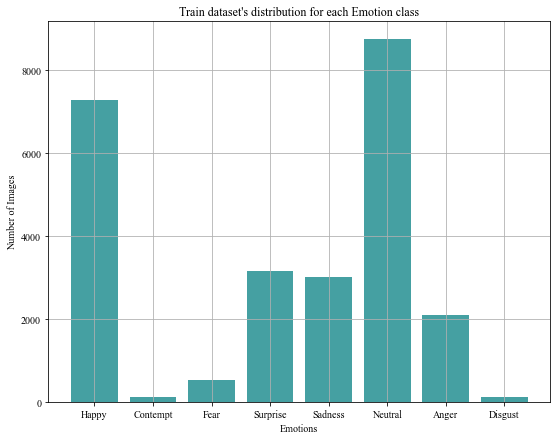

In [8]:
# data_path_ck = "/Users/gengyunxin/Documents/研究生/ICALT/DO/Deep-Emotion-Recognition-main/CK+48"
# data, labels = load_data(data_path_ck)
data_path_fer_train = '/Users/gengyunxin/Documents/研究生/ICALT/dataset/fer2013_plus/Training'
X_train, y_train = load_data(data_path_fer_train, mode='Train')

[INFO] Dataset Loading...

Loading : 865 images of category Happy
Loading : 13 images of category Contempt
Loading : 62 images of category Fear
Loading : 415 images of category Surprise
Loading : 351 images of category Sadness
Loading : 1182 images of category Neutral
Loading : 287 images of category Anger
Loading : 24 images of category Disgust

Total number of uploaded data:  3199 , with data shape (48, 48, 3)


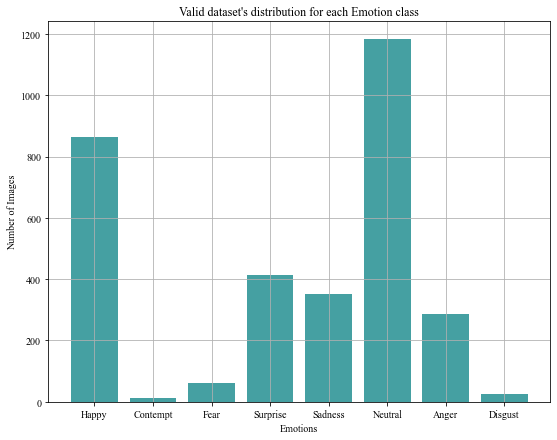

In [10]:
data_path_fer_valid = '/Users/gengyunxin/Documents/研究生/ICALT/dataset/fer2013_plus/PublicTest'
X_valid, y_valid = load_data(data_path_fer_valid, mode='Valid')

[INFO] Dataset Loading...

Loading : 893 images of category Happy
Loading : 16 images of category Contempt
Loading : 83 images of category Fear
Loading : 396 images of category Surprise
Loading : 384 images of category Sadness
Loading : 1090 images of category Neutral
Loading : 273 images of category Anger
Loading : 18 images of category Disgust

Total number of uploaded data:  3153 , with data shape (48, 48, 3)


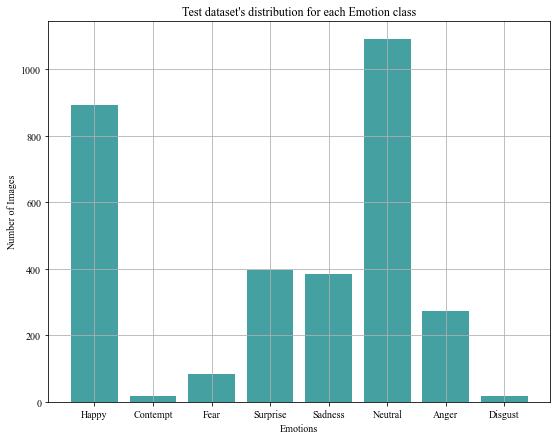

In [34]:
data_path_fer_test = '/Users/gengyunxin/Documents/研究生/ICALT/dataset/fer2013_plus/PrivateTest'
X_test, y_test = load_data(data_path_fer_test, mode='Test')

In [12]:
# Split the dataset into two subsets (70%-30%). The first one will be used for training.
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=3)
print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")
# The second subset will be split into validation and test set (50%-50%).
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=3)
print(f"X_valid has shape: {X_valid.shape}")
print(f"y_valid has shape: {y_valid.shape}\n")
print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}\n")
print(f"X_train + X_valid + X_test = {X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]} samples in total")

X_train has shape: (25060, 48, 48, 3)
y_train has shape: (25060, 8)

X_valid has shape: (3199, 48, 48, 3)
y_valid has shape: (3199, 8)

X_test has shape: (3153, 48, 48, 3)
y_test has shape: (3153, 8)

X_train + X_valid + X_test = 31412 samples in total


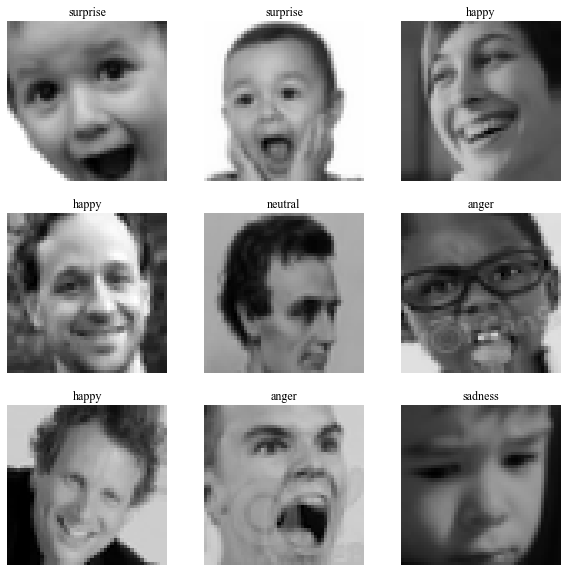

In [38]:
# Map the emotion-categories
# mapping = {0:'anger', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprised', 6:'normal'}
mapping = {0:'anger', 1:'contempt', 2:'disgust', 3:'fear', 4:'happy', 5:'neutral', 6:'sadness', 7:'surprise'}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,
                              zoom_range=0.15,
                              #width_shift_range=0.2,
                              brightness_range=(.6, 1.2),
                              shear_range=.15,
                              #height_shift_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(trainAug.flow(X_train, y_train, batch_size=1)):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(image)/255.)
    plt.title(mapping[np.argmax(label)])
    plt.axis("off")
plt.savefig('/Users/gengyunxin/Documents/研究生/ICALT/result/sample_plot.eps', format='eps', dpi=1000)
plt.savefig('/Users/gengyunxin/Documents/研究生/ICALT/result/sample_plot.png')
# plt.show()

### Create the model

In [39]:
def build_model():
    """
    Create the new model.
  
    This function loads a pre-trained EfficientNetB0 model on Imagenet,
    adds an Input layer at the beggining, and 3 more layers at the end
    (i.e GlobalAveragePooling2D, Dropout, Dense).

    Args:
        No value
   
    Returns:
        model (tensorflow.python.keras.engine.functional.Functional): The compiled model
    """
    
    inputs = Input(shape=(48, 48, 3))
    base_model = EfficientNetB0(include_top=False, weights='imagenet',
                                drop_connect_rate=0.33, input_tensor=inputs)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(.1, name="top_dropout")(x)
    # outputs = Dense(6, activation='softmax')(x)
    outputs = Dense(8, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [40]:
# Create an object of the model
model = build_model()

### Save the summary and the plot of the model into files

In [ ]:
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

#print(model.summary())
# plot_model(model, to_file='model.png')

### Train the model

In [42]:
EPOCHS = 100
batch_size = 32
filepath = "/Users/gengyunxin/Documents/研究生/ICALT/checkpoint/ferplus_8.hdf5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, earlystopping, rlrop]

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(X_train) // batch_size,
                 validation_data=(X_valid, y_valid),
                 epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 100 epochs...

Epoch 1/100
783/783 [==============================] - ETA: 0s - loss: 1.1187 - accuracy: 0.5973
Epoch 00001: val_accuracy improved from -inf to 0.66364, saving model to /Users/gengyunxin/Documents/研究生/ICALT/checkpoint/ferplus_8.hdf5
783/783 [==============================] - 236s 301ms/step - loss: 1.1187 - accuracy: 0.5973 - val_loss: 0.9426 - val_accuracy: 0.6636
Epoch 2/100
783/783 [==============================] - ETA: 0s - loss: 0.9564 - accuracy: 0.6586
Epoch 00002: val_accuracy improved from 0.66364 to 0.70553, saving model to /Users/gengyunxin/Documents/研究生/ICALT/checkpoint/ferplus_8.hdf5
783/783 [==============================] - 241s 308ms/step - loss: 0.9564 - accuracy: 0.6586 - val_loss: 0.8408 - val_accuracy: 0.7055
Epoch 3/100
783/783 [==============================] - ETA: 0s - loss: 0.8508 - accuracy: 0.6971
Epoch 00003: val_accuracy improved from 0.70553 to 0.72085, saving model to /Users/gengyunxin/Documents/研究生/ICALT/check

### Plot the learning curves

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


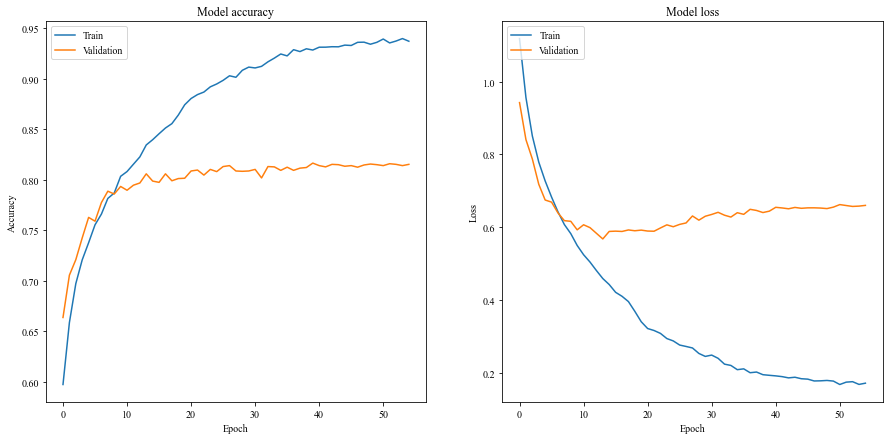

In [43]:
# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(15, 7))

# Plot training & validation accuracy values
fig.add_subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/Users/gengyunxin/Documents/研究生/ICALT/result/Acc_8.png')
plt.savefig('/Users/gengyunxin/Documents/研究生/ICALT/result/Acc_8.eps', format='eps', dpi=1000)

# Plot training & validation loss values
fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/Users/gengyunxin/Documents/研究生/ICALT/result/Loss_8.png')
plt.savefig('/Users/gengyunxin/Documents/研究生/ICALT/result/Loss_8.eps', format='eps', dpi=1000)

# Load the weights with which the model managed to achieve the highest validation accuracy

In [45]:
model.load_weights('/Users/gengyunxin/Documents/研究生/ICALT/checkpoint/ferplus_8.hdf5')

### Pick randomly some images that the model hasn't seen yet and let it predict. The barplot on the write shows the confidence of its prediction

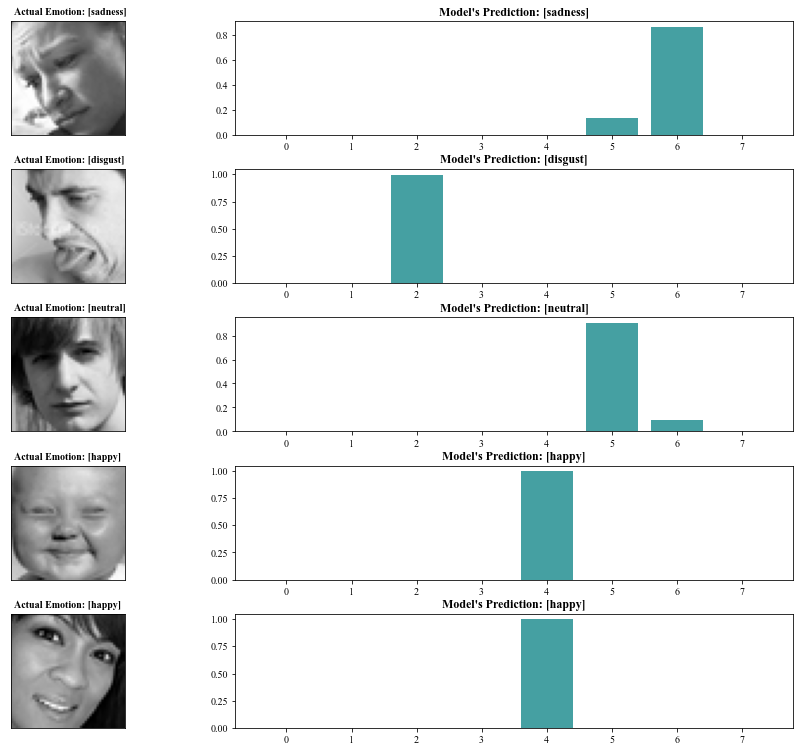

In [48]:
samples = np.random.choice(len(X_test), 5)

predictions = model.predict(X_test[samples], verbose=0)

fig, axes = plt.subplots(len(samples), 2, figsize=(18, 13))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, X_test[samples], y_test[samples])):

    axes[i, 0].imshow(np.squeeze(image/255.))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(1., -3, f'Actual Emotion: [{mapping[np.argmax(label)]}]', weight='bold')

    axes[i, 1].bar(np.arange(len(prediction)), prediction, color=tl_hex)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Model's Prediction: [{mapping[np.argmax(prediction)]}]", weight='bold')
plt.savefig('/Users/gengyunxin/Documents/研究生/ICALT/result/test.png')
plt.savefig('/Users/gengyunxin/Documents/研究生/ICALT/result/test.eps', format='eps', dpi=1000)

In [49]:
def show_confusion_matrix(X_test, y_test):
    """
    Show the confusion matrix of the unseen data.
  
    This function takes a fraction of the dataset that has not seen yet and
    tries to categorize each image into one of the 6 classes. The results are
    represented through a confusion matrix.

    Args:
        X_test (numpy.ndarray): unseen images
        y_test (numpy.ndarray): their corresponding labels
   
    Returns:
        No value
    """

    # Predict the test set (the system hasn't seen it yet)
    predictions = model.predict(X_test, verbose=0)
    
    y_classes =  np.argmax(predictions, axis=1)
    actual_classes =  np.argmax(y_test, axis=1)

    pred_labels = [mapping[element] for element in y_classes]
    actual_labels = [mapping[element] for element in actual_classes]

    # Create a dictionary
    data = {'y_Actual':    actual_labels,
            'y_Predicted': pred_labels}

    # Create a dataframe
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

    # Calculate model's accuracy
    correct_predictions = sum(map(lambda x, y: x == y, pred_labels, actual_labels))
    all_samples = len(y_test)
    print(f"Final accuracy: {correct_predictions/all_samples * 100:.2f}%")

    # Plot the confusion matrix
    _, ax = plt.subplots(figsize=(10,8)) 
    sn.heatmap(confusion_matrix, annot = True, ax=ax)
    plt.savefig('/Users/gengyunxin/Documents/研究生/ICALT/result/confusion_matrix.png')
    plt.savefig('/Users/gengyunxin/Documents/研究生/ICALT/result/confusion_matrix.eps', format='eps', dpi=1000)
    plt.show()

Final accuracy: 81.54%


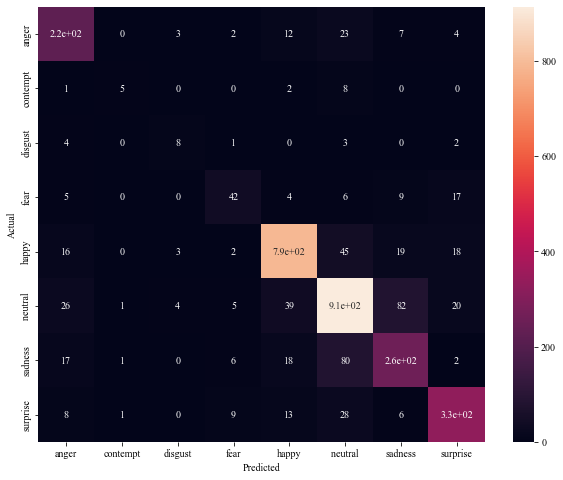

In [51]:
show_confusion_matrix(X_test, y_test)